Sistem: cuda
Veri okunuyor: /content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5
Sensör Sayısı: 207 | Toplam Adım: 34272
Pearson Korelasyon Grafı hesaplanıyor...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(



>>> Cheb-LSTM Eğitiliyor... (Dropout Active)
Epoch 005 | Train Loss: 0.1488 | Val Loss: 0.1375
Epoch 010 | Train Loss: 0.1468 | Val Loss: 0.1311
Epoch 015 | Train Loss: 0.1461 | Val Loss: 0.1344
Epoch 020 | Train Loss: 0.1459 | Val Loss: 0.1308
Epoch 025 | Train Loss: 0.1457 | Val Loss: 0.1300
Epoch 030 | Train Loss: 0.1456 | Val Loss: 0.1290
!! Erken Durdurma: Epoch 34

>>> Cheb-LSTM FINAL TEST SONUÇLARI (Gerçek Birimler) <<<
Metrik     | Değer     
-------------------------
MAE        | 2.5796
RMSE       | 6.4547
MAPE       | 5.98%
-------------------------

>>> CorrAttn-Net Eğitiliyor... (Dropout Active)
Epoch 005 | Train Loss: 0.1419 | Val Loss: 0.1285
Epoch 010 | Train Loss: 0.1400 | Val Loss: 0.1275
Epoch 015 | Train Loss: 0.1395 | Val Loss: 0.1273
Epoch 020 | Train Loss: 0.1393 | Val Loss: 0.1274
Epoch 025 | Train Loss: 0.1388 | Val Loss: 0.1278
Epoch 030 | Train Loss: 0.1387 | Val Loss: 0.1284
Epoch 035 | Train Loss: 0.1385 | Val Loss: 0.1273
Epoch 040 | Train Loss: 0.1385 | V

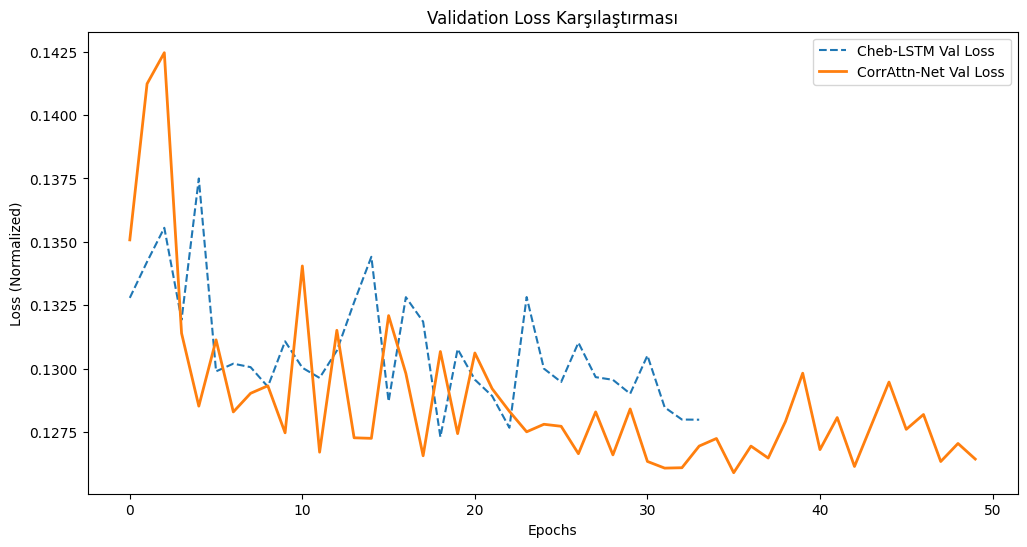

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
import time
import copy
import matplotlib.pyplot as plt
import os
import math

# =============================================================================
# BÖLÜM 1: DATA LOADER (GÜNCELLENDİ: Scaler Saklama Eklendi)
# =============================================================================

class TrafficDataLoader:
    def __init__(self, data_path, seq_len=12, horizon=1, train_ratio=0.7):
        self.seq_len = seq_len
        self.horizon = horizon
        self.data_path = data_path
        self.train_ratio = train_ratio

        print(f"Veri okunuyor: {data_path}")
        try:
            self.df = pd.read_hdf(data_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"HATA: Dosya bulunamadı -> {data_path}")

        self.data = self.df.values
        self.num_nodes = self.data.shape[1]
        self.num_samples = self.data.shape[0]

        # --- NORMALİZASYON BİLGİLERİNİ SAKLA ---
        # Metrikleri gerçek birime (km/h) çevirmek için bunlara ihtiyacımız var.
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data_norm = (self.data - self.mean) / self.std

        self.split_idx = int(self.num_samples * self.train_ratio)
        print(f"Sensör Sayısı: {self.num_nodes} | Toplam Adım: {self.num_samples}")

    def get_pearson_correlation_graph(self, threshold=0.5):
        print("Pearson Korelasyon Grafı hesaplanıyor...")
        train_df = self.df.iloc[:self.split_idx]
        corr_matrix = train_df.corr(method='pearson').values
        adj = np.abs(corr_matrix)
        adj[adj < threshold] = 0
        np.fill_diagonal(adj, 1.0) # Kendine bağlantı (Self-loop)
        return adj

    def get_scaled_laplacian(self, adj):
        if not sp.isspmatrix(adj):
            adj = sp.coo_matrix(adj)
        d = np.array(adj.sum(1))
        d_inv_sqrt = np.power(d, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        normalized_laplacian = sp.eye(adj.shape[0]) - d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

        try:
            lambda_max, _ = eigs(normalized_laplacian, k=1, which='LM')
            lambda_max = lambda_max.real[0]
        except:
            lambda_max = 2.0

        L_tilde = (2 * normalized_laplacian / lambda_max) - sp.eye(adj.shape[0])
        return torch.FloatTensor(L_tilde.toarray())

    def get_iterator(self, type='train', batch_size=64):
        if type == 'train':
            data_source = self.data_norm[:self.split_idx]
        else:
            data_source = self.data_norm[self.split_idx:]

        num_samples = len(data_source) - self.seq_len - self.horizon
        indices = np.arange(num_samples)

        if type == 'train':
            np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i+batch_size]
            if len(batch_indices) < batch_size: continue

            X_batch, y_batch = [], []
            for idx in batch_indices:
                X_batch.append(data_source[idx : idx+self.seq_len])
                y_batch.append(data_source[idx+self.seq_len : idx+self.seq_len+self.horizon])

            yield torch.FloatTensor(np.array(X_batch)), torch.FloatTensor(np.array(y_batch))

# =============================================================================
# BÖLÜM 2: GÜNCELLENMİŞ MODELLER (Dropout Eklendi)
# =============================================================================

# --- YARDIMCI KATMAN: CHEBYSHEV GRAPH CONV ---
class ChebConvLayer(nn.Module):
    def __init__(self, in_features, out_features, k_order, L_tilde):
        super(ChebConvLayer, self).__init__()
        self.k_order = k_order
        self.L_tilde = L_tilde
        self.W = nn.Parameter(torch.FloatTensor(k_order * in_features, out_features))
        self.b = nn.Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.W)
        nn.init.constant_(self.b, 0.0)

    def forward(self, x):
        cheb_polys = [x]
        if self.k_order > 1:
            L = self.L_tilde.to(x.device)
            x1 = torch.matmul(L, x)
            cheb_polys.append(x1)
        for k in range(2, self.k_order):
            x_k = 2 * torch.matmul(L, cheb_polys[k-1]) - cheb_polys[k-2]
            cheb_polys.append(x_k)

        cheb_input = torch.cat(cheb_polys, dim=2)
        out = torch.matmul(cheb_input, self.W) + self.b
        return F.relu(out)

# --- MODEL 1: CHEBNET + LSTM (Baseline) ---
class Model_ChebLSTM(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_ChebLSTM, self).__init__()
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)
        # Dropout Eklendi
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout if dropout > 0 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # Spatial
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # Temporal
        spatial_out = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)

        lstm_out, (h_n, _) = self.lstm(spatial_out)

        # Dropout ve Final
        last_hidden = self.dropout(h_n[-1])
        out = self.fc(last_hidden)
        return out.view(batch, nodes)

# --- MODEL 2: PROPOSED (ATTENTION BASED) - GÜNCELLENDİ ---
class Model_Proposed(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_Proposed, self).__init__()

        # 1. Uzamsal
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)

        # 2. Zamansal
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=dropout if dropout > 0 else 0)

        # 3. Attention Bileşenleri
        self.W_a = nn.Linear(hidden_dim, hidden_dim)
        self.v_a = nn.Linear(hidden_dim, 1, bias=False)

        # Normalizasyon ve Dropout (Overfitting önlemi)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.fc = nn.Linear(hidden_dim * 2, 1) # Context + Hidden

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # Spatial
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # Temporal
        lstm_input = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)
        lstm_out, (h_n, _) = self.lstm(lstm_input) # lstm_out: (Batch*Nodes, Seq, Hidden)

        # --- ATTENTION MEKANİZMASI ---
        # Bahdanau Style Attention: Score = v_a * tanh(W_a * hidden)
        energy = torch.tanh(self.W_a(lstm_out))
        scores = self.v_a(energy) # (Batch*Nodes, Seq, 1)
        attn_weights = torch.softmax(scores, dim=1)

        context = torch.sum(attn_weights * lstm_out, dim=1) # (Batch*Nodes, Hidden)

        # Overfitting Önlemleri
        last_hidden = h_n[-1]
        context = self.dropout(context)
        last_hidden = self.dropout(last_hidden)

        # Final Tahmin
        combined = torch.cat([context, last_hidden], dim=1)
        out = self.fc(combined)

        return out.view(batch, nodes)

# =============================================================================
# BÖLÜM 3: EĞİTİM MOTORU (METRİKLER EKLENDİ)
# =============================================================================

def train_engine_pro(model, loader, device, epochs=100, patience=15, model_name="Model"):
    print(f"\n>>> {model_name} Eğitiliyor... (Dropout Active)")

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # Weight Decay eklendi (Regularization)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.L1Loss()

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        batch_losses = []
        for x_batch, y_batch in loader.get_iterator('train', batch_size=64):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch[:, 0, :])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for x_batch, y_batch in loader.get_iterator('test', batch_size=64):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                loss = criterion(preds, y_batch[:, 0, :])
                val_batch_losses.append(loss.item())

        epoch_val_loss = np.mean(val_batch_losses)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1:03d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"!! Erken Durdurma: Epoch {epoch+1}")
                break

    model.load_state_dict(best_model_wts)
    return train_losses, val_losses, best_val_loss

# =============================================================================
# BÖLÜM 4: DETAYLI PERFORMANS METRİKLERİ (YENİ!)
# =============================================================================

def evaluate_comprehensive(model, loader, device, model_name="Model"):
    """
    Modeli test eder, veriyi ters normalize eder ve MAE, RMSE, MAPE hesaplar.
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for x_batch, y_batch in loader.get_iterator('test', batch_size=64):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(x_batch) # (Batch, Nodes)
            target = y_batch[:, 0, :] # (Batch, Nodes)

            predictions.append(preds.cpu().numpy())
            actuals.append(target.cpu().numpy())

    # NumPy dizisine çevir
    y_pred = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(actuals, axis=0)

    # TERS NORMALİZASYON (Inverse Transform)
    # Formül: X = X_norm * std + mean
    y_pred_inv = y_pred * loader.std + loader.mean
    y_true_inv = y_true * loader.std + loader.mean

    # 0 olan değerleri MAPE hatasından korumak için maskeleme
    mask = y_true_inv > 1.0 # 1 km/h altındaki hızları ihmal et (gürültü)

    # METRİKLER
    mae = np.mean(np.abs(y_pred_inv - y_true_inv))
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    mape = np.mean(np.abs((y_pred_inv[mask] - y_true_inv[mask]) / y_true_inv[mask])) * 100

    print(f"\n>>> {model_name} FINAL TEST SONUÇLARI (Gerçek Birimler) <<<")
    print(f"{'Metrik':<10} | {'Değer':<10}")
    print("-" * 25)
    print(f"{'MAE':<10} | {mae:.4f}")
    print(f"{'RMSE':<10} | {rmse:.4f}")
    print(f"{'MAPE':<10} | {mape:.2f}%")
    print("-" * 25)

    return mae, rmse, mape

# =============================================================================
# BÖLÜM 5: ÇALIŞTIRMA (MAIN)
# =============================================================================

if __name__ == "__main__":
    # AYARLAR
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Dosya yolunu kendi Drive yoluna göre düzenle
    DATA_PATH = "/content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5"

    print(f"Sistem: {DEVICE}")

    if os.path.exists(DATA_PATH):
        # 1. Veri Yükle
        loader = TrafficDataLoader(DATA_PATH)
        adj_mx = loader.get_pearson_correlation_graph(threshold=0.6)
        L_tilde = loader.get_scaled_laplacian(adj_mx).to(DEVICE)

        # 2. Modelleri Tanımla
        model_cheb = Model_ChebLSTM(loader.num_nodes, in_features=1, hidden_dim=64, L_tilde=L_tilde, dropout=0.3).to(DEVICE)
        model_prop = Model_Proposed(loader.num_nodes, in_features=1, hidden_dim=64, L_tilde=L_tilde, dropout=0.3).to(DEVICE)

        # 3. Model 1 Eğitimi (Cheb-LSTM)
        tr_loss1, val_loss1, _ = train_engine_pro(model_cheb, loader, DEVICE, epochs=50, model_name="Cheb-LSTM")
        evaluate_comprehensive(model_cheb, loader, DEVICE, model_name="Cheb-LSTM")

        # 4. Model 2 Eğitimi (Proposed Attention)
        tr_loss2, val_loss2, _ = train_engine_pro(model_prop, loader, DEVICE, epochs=50, model_name="CorrAttn-Net")
        evaluate_comprehensive(model_prop, loader, DEVICE, model_name="CorrAttn-Net")

        # 5. Grafik Çizimi (Loss Karşılaştırması)
        plt.figure(figsize=(12, 6))
        plt.plot(val_loss1, label='Cheb-LSTM Val Loss', linestyle='--')
        plt.plot(val_loss2, label='CorrAttn-Net Val Loss', linewidth=2)
        plt.title('Validation Loss Karşılaştırması')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Normalized)')
        plt.legend()
        plt.show()

    else:
        print("Lütfen DATA_PATH değişkenini doğru dosya yolu ile güncelleyin.")

Veri okunuyor: /content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5
Sensör Sayısı: 207 | Toplam Adım: 34272
Pearson Korelasyon Grafı hesaplanıyor...

>>> LSTM Eğitiliyor...
Epoch 005 | Train: 0.2523 | Val: 0.2356
Epoch 010 | Train: 0.2427 | Val: 0.2279
Epoch 015 | Train: 0.2335 | Val: 0.2258
Epoch 020 | Train: 0.2277 | Val: 0.2241
Epoch 025 | Train: 0.2255 | Val: 0.2247
Epoch 030 | Train: 0.2242 | Val: 0.2266
Epoch 035 | Train: 0.2227 | Val: 0.2198
Epoch 040 | Train: 0.2230 | Val: 0.2175
Epoch 045 | Train: 0.2220 | Val: 0.2181
Epoch 050 | Train: 0.2211 | Val: 0.2185
>>> LSTM Sonuçlar: MAE: 4.41 | RMSE: 10.31 | MAPE: %9.57

>>> Cheb-LSTM Eğitiliyor...
Epoch 005 | Train: 0.1478 | Val: 0.1333
Epoch 010 | Train: 0.1465 | Val: 0.1283
Epoch 015 | Train: 0.1460 | Val: 0.1319
Epoch 020 | Train: 0.1458 | Val: 0.1310
Epoch 025 | Train: 0.1456 | Val: 0.1300
Epoch 030 | Train: 0.1453 | Val: 0.1303
Epoch 035 | Train: 0.1454 | Val: 0.1290
!! Erken Durdurma (Early Stopping)
>>> Cheb-LSTM Sonuçla

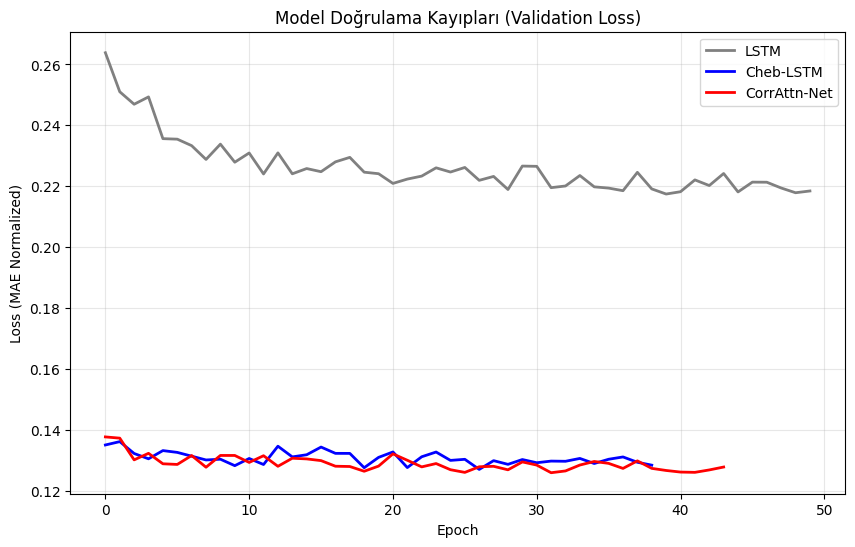

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import eigs
import time
import copy
import matplotlib.pyplot as plt
import os

# =============================================================================
# 1. VERİ YÜKLEYİCİ VE GRAF OLUŞTURUCU
# =============================================================================

class TrafficDataLoader:
    def __init__(self, data_path, seq_len=12, horizon=1, train_ratio=0.7):
        self.seq_len = seq_len
        self.horizon = horizon
        self.data_path = data_path
        self.train_ratio = train_ratio

        print(f"Veri okunuyor: {data_path}")
        try:
            self.df = pd.read_hdf(data_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"HATA: Dosya bulunamadı -> {data_path}")

        self.data = self.df.values
        self.num_nodes = self.data.shape[1]
        self.num_samples = self.data.shape[0]

        # Normalizasyon parametrelerini sakla (Geri dönüşüm için)
        self.mean = self.data.mean()
        self.std = self.data.std()
        self.data_norm = (self.data - self.mean) / self.std

        self.split_idx = int(self.num_samples * self.train_ratio)
        print(f"Sensör Sayısı: {self.num_nodes} | Toplam Adım: {self.num_samples}")

    def get_pearson_correlation_graph(self, threshold=0.5):
        print("Pearson Korelasyon Grafı hesaplanıyor...")
        train_df = self.df.iloc[:self.split_idx]
        corr_matrix = train_df.corr(method='pearson').values
        adj = np.abs(corr_matrix)
        adj[adj < threshold] = 0
        np.fill_diagonal(adj, 1.0)
        return adj

    def get_scaled_laplacian(self, adj):
        if not sp.isspmatrix(adj):
            adj = sp.coo_matrix(adj)
        d = np.array(adj.sum(1))
        d_inv_sqrt = np.power(d, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        normalized_laplacian = sp.eye(adj.shape[0]) - d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)

        try:
            lambda_max, _ = eigs(normalized_laplacian, k=1, which='LM')
            lambda_max = lambda_max.real[0]
        except:
            lambda_max = 2.0

        L_tilde = (2 * normalized_laplacian / lambda_max) - sp.eye(adj.shape[0])
        return torch.FloatTensor(L_tilde.toarray())

    def get_iterator(self, type='train', batch_size=64):
        if type == 'train':
            data_source = self.data_norm[:self.split_idx]
        else:
            data_source = self.data_norm[self.split_idx:]

        num_samples = len(data_source) - self.seq_len - self.horizon
        indices = np.arange(num_samples)

        if type == 'train':
            np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i+batch_size]
            if len(batch_indices) < batch_size: continue

            X_batch, y_batch = [], []
            for idx in batch_indices:
                X_batch.append(data_source[idx : idx+self.seq_len])
                y_batch.append(data_source[idx+self.seq_len : idx+self.seq_len+self.horizon])

            yield torch.FloatTensor(np.array(X_batch)), torch.FloatTensor(np.array(y_batch))

# =============================================================================
# 2. MODEL MİMARİLERİ
# =============================================================================

# --- MODEL 1: LSTM (Sadece LSTM) ---
class Model_LSTM(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64, dropout=0.3):
        super(Model_LSTM, self).__init__()
        # Input size = num_nodes (her sensör bir feature)
        self.lstm = nn.LSTM(input_size=num_nodes, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        # x shape: (Batch, Seq, Nodes)
        lstm_out, _ = self.lstm(x)
        # Son adımı al ve dropout uygula
        last_step = self.dropout(lstm_out[:, -1, :])
        out = self.fc(last_step)
        return out

# --- YARDIMCI KATMAN: CHEBYSHEV CONV ---
class ChebConvLayer(nn.Module):
    def __init__(self, in_features, out_features, k_order, L_tilde):
        super(ChebConvLayer, self).__init__()
        self.k_order = k_order
        self.L_tilde = L_tilde
        self.W = nn.Parameter(torch.FloatTensor(k_order * in_features, out_features))
        self.b = nn.Parameter(torch.FloatTensor(out_features))
        nn.init.xavier_uniform_(self.W)
        nn.init.constant_(self.b, 0.0)

    def forward(self, x):
        cheb_polys = [x]
        if self.k_order > 1:
            L = self.L_tilde.to(x.device)
            x1 = torch.matmul(L, x)
            cheb_polys.append(x1)
        for k in range(2, self.k_order):
            x_k = 2 * torch.matmul(L, cheb_polys[k-1]) - cheb_polys[k-2]
            cheb_polys.append(x_k)
        cheb_input = torch.cat(cheb_polys, dim=2)
        out = torch.matmul(cheb_input, self.W) + self.b
        return F.relu(out)

# --- MODEL 2: Cheb-LSTM (GCN + LSTM) ---
class Model_ChebLSTM(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_ChebLSTM, self).__init__()
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # 1. Spatial Conv
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # 2. Temporal LSTM
        spatial_out = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)
        lstm_out, (h_n, _) = self.lstm(spatial_out)

        # 3. Output
        last_hidden = self.dropout(h_n[-1])
        out = self.fc(last_hidden)
        return out.view(batch, nodes)

# --- MODEL 3: CorrAttn-Net (Proposed: GCN + LSTM + Attention) ---
class Model_CorrAttn_Net(nn.Module):
    def __init__(self, num_nodes, in_features, hidden_dim, L_tilde, k_order=3, dropout=0.3):
        super(Model_CorrAttn_Net, self).__init__()
        self.cheb_conv = ChebConvLayer(in_features, hidden_dim, k_order, L_tilde)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # Attention
        self.W_a = nn.Linear(hidden_dim, hidden_dim)
        self.v_a = nn.Linear(hidden_dim, 1, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        if x.dim() == 3: x = x.unsqueeze(-1)
        batch, seq, nodes, feat = x.shape

        # 1. Spatial
        x_reshaped = x.view(batch * seq, nodes, feat)
        spatial_out = self.cheb_conv(x_reshaped)

        # 2. Temporal
        lstm_input = spatial_out.view(batch, seq, nodes, -1).permute(0, 2, 1, 3).contiguous().view(batch * nodes, seq, -1)
        lstm_out, (h_n, _) = self.lstm(lstm_input)

        # 3. Attention
        energy = torch.tanh(self.W_a(lstm_out))
        scores = self.v_a(energy)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # 4. Final
        last_hidden = h_n[-1]
        context = self.dropout(context)
        last_hidden = self.dropout(last_hidden)

        combined = torch.cat([context, last_hidden], dim=1)
        out = self.fc(combined)
        return out.view(batch, nodes)

# =============================================================================
# 3. EĞİTİM VE TEST MOTORU
# =============================================================================

def train_engine(model, loader, device, epochs=50, model_name="Model"):
    print(f"\n>>> {model_name} Eğitiliyor...")

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    criterion = nn.L1Loss() # MAE

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict())
    patience_counter = 0
    patience = 12

    for epoch in range(epochs):
        model.train()
        batch_losses = []
        for x_batch, y_batch in loader.get_iterator('train', batch_size=64):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch[:, 0, :])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)

        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for x_batch, y_batch in loader.get_iterator('test', batch_size=64):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                preds = model(x_batch)
                loss = criterion(preds, y_batch[:, 0, :])
                val_batch_losses.append(loss.item())

        epoch_val_loss = np.mean(val_batch_losses)
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1:03d} | Train: {epoch_train_loss:.4f} | Val: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("!! Erken Durdurma (Early Stopping)")
                break

    model.load_state_dict(best_weights)
    return train_losses, val_losses

def evaluate_metrics(model, loader, device):
    """ Gerçek birimlerde (km/h) metrikleri hesaplar """
    model.eval()
    preds_list, true_list = [], []

    with torch.no_grad():
        for x_batch, y_batch in loader.get_iterator('test', batch_size=64):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            preds_list.append(preds.cpu().numpy())
            true_list.append(y_batch[:, 0, :].cpu().numpy())

    y_pred = np.concatenate(preds_list, axis=0)
    y_true = np.concatenate(true_list, axis=0)

    # Ters Normalizasyon
    y_pred = y_pred * loader.std + loader.mean
    y_true = y_true * loader.std + loader.mean

    mask = y_true > 1.0 # 0'a bölme hatasını önle
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    mape = np.mean(np.abs((y_pred[mask] - y_true[mask]) / y_true[mask])) * 100

    return mae, rmse, mape

# =============================================================================
# 4. ANA ÇALIŞTIRMA (MAIN)
# =============================================================================

if __name__ == "__main__":
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Dosya yolunu kontrol et
    DATA_PATH = "/content/drive/MyDrive/Proje-doktora_1_1/DCRNN/metr-la.h5"

    if os.path.exists(DATA_PATH):
        # 1. Veri Hazırlığı
        loader = TrafficDataLoader(DATA_PATH)
        adj_mx = loader.get_pearson_correlation_graph(threshold=0.6)
        L_tilde = loader.get_scaled_laplacian(adj_mx).to(DEVICE)

        # 2. Modellerin Listesi (Burada isimler güncellendi)
        models_to_train = [
            ("LSTM", Model_LSTM(loader.num_nodes, hidden_dim=64, dropout=0.3).to(DEVICE)),
            ("Cheb-LSTM", Model_ChebLSTM(loader.num_nodes, 1, 64, L_tilde, dropout=0.3).to(DEVICE)),
            ("CorrAttn-Net", Model_CorrAttn_Net(loader.num_nodes, 1, 64, L_tilde, dropout=0.3).to(DEVICE))
        ]

        results = {"Model": [], "MAE": [], "RMSE": [], "MAPE": [], "Loss_History": []}

        # 3. Döngüsel Eğitim
        for name, model in models_to_train:
            # Eğit
            _, val_losses = train_engine(model, loader, DEVICE, epochs=50, model_name=name)

            # Test Et
            mae, rmse, mape = evaluate_metrics(model, loader, DEVICE)

            # Kaydet
            results["Model"].append(name)
            results["MAE"].append(mae)
            results["RMSE"].append(rmse)
            results["MAPE"].append(mape)
            results["Loss_History"].append(val_losses)

            print(f">>> {name} Sonuçlar: MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: %{mape:.2f}")

        # 4. Final Tablo
        print("\n" + "="*55)
        print(f"{'MODEL':<25} | {'MAE':<8} | {'RMSE':<8} | {'MAPE':<8}")
        print("-" * 55)
        for i in range(len(results["Model"])):
            print(f"{results['Model'][i]:<25} | {results['MAE'][i]:.3f}    | {results['RMSE'][i]:.3f}    | {results['MAPE'][i]:.2f}%")
        print("="*55)

        # 5. Grafik
        plt.figure(figsize=(10, 6))
        colors = ['gray', 'blue', 'red']
        for i, hist in enumerate(results["Loss_History"]):
            plt.plot(hist, label=results["Model"][i], color=colors[i], linewidth=2)
        plt.title("Model Doğrulama Kayıpları (Validation Loss)")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (MAE Normalized)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    else:
        print("Dosya yolu hatası! Lütfen DATA_PATH değişkenini kontrol edin.")